In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from tqdm import tqdm
import seaborn as sns
import re
import datetime
import os
import random
import shap  

In [185]:
import json

h3_l7_df = pd.read_json("h3_l7_df.json", orient="records", lines=True)

In [186]:
# 設定plt環境
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [187]:
class Regressor(nn.Module):
    """
    用於迴歸任務的神經網絡模型 Regressor。
    
    結構:
    - 兩層隱藏層，並使用 ReLU 激活函數
    - 最後一層為線性層，不使用激活函數（適用於迴歸）
    """
    def __init__(self, input_size=2, hidden_size=32, output_size=1):
        super().__init__()
        # 定義三層全連接層
        self.fc1 = nn.Linear(input_size, hidden_size)     # 第一層：輸入層到隱藏層
        self.fc2 = nn.Linear(hidden_size, hidden_size)    # 第二層：隱藏層到隱藏層
        self.fc3 = nn.Linear(hidden_size, output_size)    # 第三層：隱藏層到輸出層

        # 初始化權重和偏置
        nn.init.normal_(self.fc1.weight, std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight, std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight, std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        # 前向傳播過程
        output = F.relu(self.fc1(input))  # 第一層 + ReLU 激活
        output = F.relu(self.fc2(output)) # 第二層 + ReLU 激活
        output = self.fc3(output)         # 第三層（不使用激活函數）
        return output

In [189]:
# 設定訓練、驗證和測試集的比例
train_proportion = 0.7  

train_size = int(h3_l7_df.shape[0]*train_proportion)

seed = 7578 #666
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# h3_l7_id = np.random.choice(spatial_data.shape[0], spatial_data.shape[0])
# spatial_data = spatial_data[h3_l7_id]
# train_spatial_data = spatial_data[:train_size, :]
# test_spatial_data = spatial_data[train_size:, :]

# 隨機打亂 DataFrame
shuffled_h3_l7_df = h3_l7_df.sample(frac=1, random_state=seed).reset_index(drop=True)

# 分割訓練集和測試集
train_h3_l7_df = shuffled_h3_l7_df.iloc[:train_size]
test_h3_l7_df = shuffled_h3_l7_df.iloc[train_size:]

In [190]:
# 將 h3_l7_df 資料框中的 'id' 列移除，僅保留數據進行正規化
shuffled_spatial_data = shuffled_h3_l7_df.drop('id', axis=1).drop('police', axis=1)


# # # 對數據進行正規化：將每個數據列的最小值調整為 0，最大值調整為 1
normalized_spatial_data = (shuffled_spatial_data - shuffled_spatial_data.min()) / (shuffled_spatial_data.max() - shuffled_spatial_data.min())

#設定OHCA正規化反函數 方便把預測結果返回原本scale
ohca_reguli_inverse = (h3_l7_df.ohca.max()-h3_l7_df.ohca.min()) + h3_l7_df.ohca.min()

# 將 DataFrame 轉換為 numpy array，並設定數據類型為 np.float64
spatial_data = np.array(normalized_spatial_data).astype(np.float64)


train_spatial_data = spatial_data[:train_size, :]
test_spatial_data = spatial_data[train_size:, :]


In [191]:
class Regressor(nn.Module):
    """
    用於迴歸任務的神經網絡模型 Regressor。
    
    結構:
    - 兩層隱藏層，並使用 ReLU 激活函數
    - 最後一層為線性層，不使用激活函數（適用於迴歸）
    """
    def __init__(self, input_size=2, hidden_size=32, output_size=1):
        super().__init__()
        # 定義三層全連接層
        self.fc1 = nn.Linear(input_size, hidden_size)     # 第一層：輸入層到隱藏層
        self.fc2 = nn.Linear(hidden_size, hidden_size)    # 第二層：隱藏層到隱藏層
        self.fc3 = nn.Linear(hidden_size, output_size)    # 第三層：隱藏層到輸出層

        # 初始化權重和偏置
        nn.init.normal_(self.fc1.weight, std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight, std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight, std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        # 前向傳播過程
        output = F.relu(self.fc1(input))  # 第一層 + ReLU 激活
        output = F.relu(self.fc2(output)) # 第二層 + ReLU 激活
        output = self.fc3(output)         # 第三層（不使用激活函數）
        return output

In [192]:
window_size = 1

def train_reg(spatial_data, 
              s_net,
              s_net_optim, 
              window_size, iter_num=5000):
    """
    訓練 s_net  網絡來預測 spatial_data 中的數據。
    
    參數:
    - spatial_data: numpy array，包含訓練數據
    - s_net: 神經網絡模型
    - s_net_optim: 優化器
    - window_size: 每次迭代的隨機取樣大小
    - iter_num: 訓練迭代次數
    
    返回:
    - loss_array: 每次迭代的損失值
    - t_fea_array, s_fea_array: 用於存儲特徵的暫時性陣列（目前未使用）
    """

    loss_array = []     # 儲存每次迭代的損失
    t_fea_array = []    # 預留用於儲存暫時性特徵的空列表
    s_fea_array = []    # 預留用於儲存暫時性特徵的空列表

    for _ in tqdm(range(iter_num)):
        
        # 隨機選擇一組數據索引
        h3_l7_id = np.random.choice(spatial_data.shape[0] - 1, window_size)

        # s_net 輸入特徵向量並計算輸出
        # s_fea = s_net(torch.autograd.Variable(torch.FloatTensor(spatial_data[h3_l7_id, :-1])))

        # 提取目標變數（即輸入的最後一列數據）並轉為 Tensor
        ohca = spatial_data[h3_l7_id, -1].reshape(-1, 1)
        ohca = torch.autograd.Variable(torch.FloatTensor(ohca))

        # p_pred 用於預測目標變數
        p_pred = s_net(torch.autograd.Variable(torch.FloatTensor(spatial_data[h3_l7_id, :-1]))).reshape(-1, 1)

        # 定義均方誤差損失
        mseloss = torch.nn.MSELoss(reduction='sum')
        loss = mseloss(p_pred, ohca)
        
        # 清空前一次計算的梯度
        s_net_optim.zero_grad()
        
        
        # 計算損失的梯度
        # loss.backward()
        autograd.backward(loss)

        # 更新神經網絡參數
        s_net_optim.step()
        
        # 儲存損失值
        loss_array.append(loss.detach().cpu().numpy())

    return loss_array, t_fea_array, s_fea_array

# 初始化模型和優化器
s_net = Regressor(input_size=spatial_data.shape[1] - 1, hidden_size=spatial_data.shape[1] * 2, output_size=1)
s_net_optim = optim.Adam(s_net.parameters(), lr=1e-3, weight_decay=1e-5)

iter_num=30000
# 執行訓練過程
loss_array, t_fea_array, s_fea_array = train_reg(train_spatial_data, s_net,
                                                 s_net_optim,
                                                 window_size, iter_num)

 10%|▉         | 2911/30000 [00:02<00:27, 1002.50it/s]


KeyboardInterrupt: 

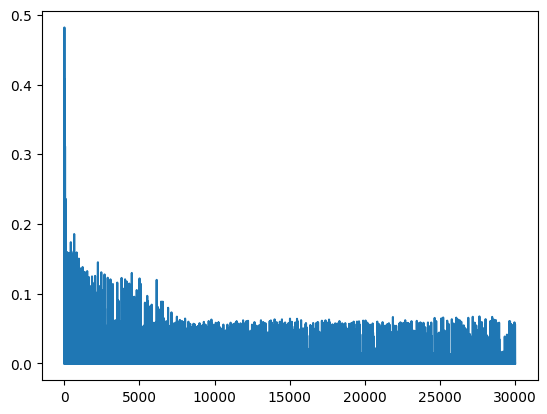

In [ ]:
plt.plot(np.array(loss_array).reshape(iter_num))

In [ ]:
y_head_train = s_net(torch.autograd.Variable(torch.FloatTensor(train_spatial_data[:, :-1]))).detach().numpy()*ohca_reguli_inverse
y_train = train_spatial_data[:, -1]*ohca_reguli_inverse
y_head_test = s_net(torch.autograd.Variable(torch.FloatTensor(test_spatial_data[:, :-1]))).detach().numpy()*ohca_reguli_inverse
y_test = test_spatial_data[:, -1].reshape(-1, 1)*ohca_reguli_inverse


Text(0, 0.5, 'Reality')

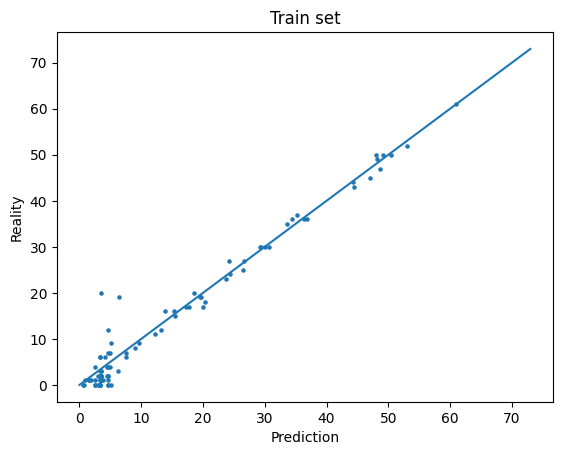

In [ ]:
plt.scatter(y_head_train,
            y_train,
            s = 5)
plt.plot([0, 73], [0, 73])
plt.title('Train set')
plt.xlabel('Prediction')
plt.ylabel('Reality')

Text(0, 0.5, 'Reality')

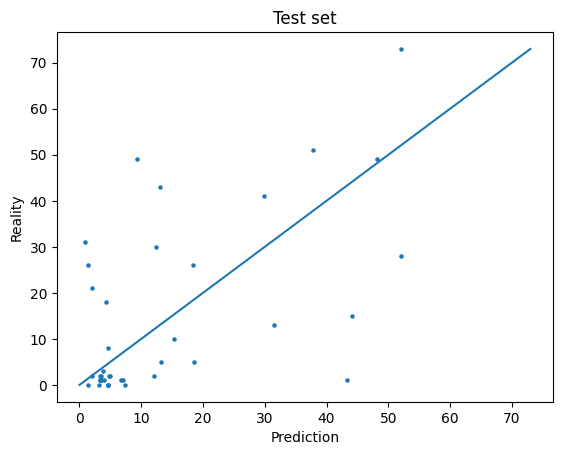

In [ ]:
plt.scatter(y_head_test,
            y_test,
            s = 5)
plt.plot([0, 73], [0, 73])
plt.title('Test set')
plt.xlabel('Prediction')
plt.ylabel('Reality')

Text(0, 0.5, 'Number of OHCA')

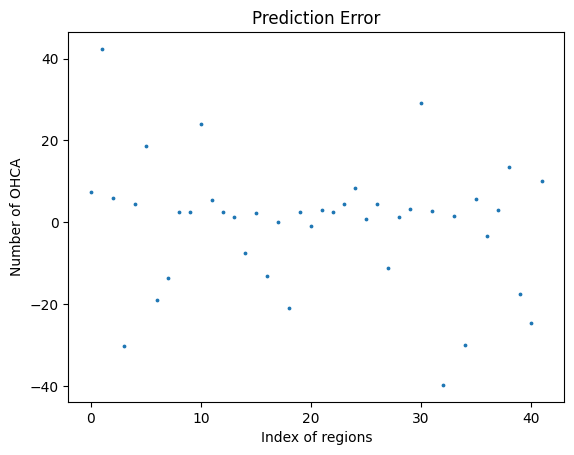

In [ ]:
plt.scatter(np.arange(test_spatial_data.shape[0]),
            y_head_test- y_test,
            s = 3)
plt.title('Prediction Error')
plt.xlabel('Index of regions')
plt.ylabel('Number of OHCA')

C:\Users\Yuan\AppData\Local\Temp\ipykernel_22976\690629878.py:2: RuntimeWarning: divide by zero encountered in divide
  (y_head_test- y_test)/test_spatial_data[:, -1].reshape(-1, 1)/ohca_reguli_inverse,


Text(0, 0.5, 'Number of OHCA')

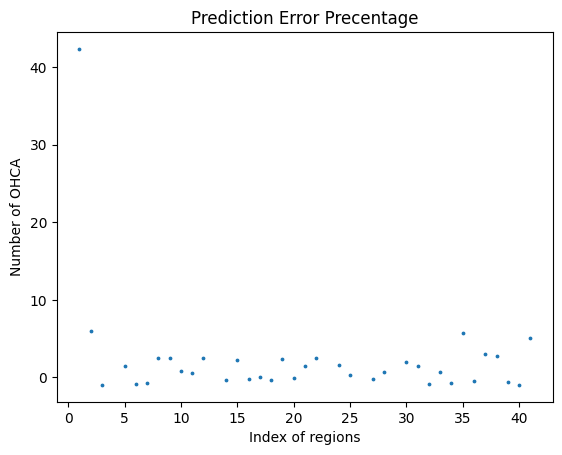

In [ ]:
plt.scatter(np.arange(test_spatial_data.shape[0]),
            (y_head_test- y_test)/test_spatial_data[:, -1].reshape(-1, 1)/ohca_reguli_inverse,
            s = 3)
plt.title('Prediction Error Precentage')
plt.xlabel('Index of regions')
plt.ylabel('Number of OHCA')


In [ ]:
# mape_list = (y_head_test-y_test)/(test_spatial_data[:, -1].reshape(-1, 1)*h3_l7_df.ohca.max()+1)

# mape = mape_list[mape_list != np.inf].sum()/mape_list.shape[0]

mae = np.abs(y_head_test-y_test)
ans_mae = mae.sum()/mae.shape[0]

print('MAE of test set= ',ans_mae)

# 計算殘差變異
ss_residual = np.sum((y_test - y_head_test) ** 2)

# 計算總變異量
ss_total = np.sum((y_test - np.mean(y_test)) ** 2)

# 計算 R²
r_squared = 1 - (ss_residual / ss_total)

n = mae.shape[0]          # Number of data points
p = train_spatial_data.shape[1]            # Number of predictors

# Adjusted R-squared calculation
r_squared_adj = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

print("R² of test set= ", r_squared)
print("ADJ R² of test set= ", r_squared_adj)

MAE of test set=  10.659901867310206
R² of test set=  0.29586266555434504
ADJ R² of test set=  3.6245118829338048
